## Аналитический отчет для SMM-отдела компании Skillbox

<br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Необходимо проанализировать влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделать аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Составить перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [2]:
import vk_api
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [152]:
DAYS_OF_WEEK={0:'Monday',1:'Tuesday', 2:'Wednsday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
IMPRESSION_TYPES = ['views', 'likes', 'reposts', 'comments']
TITLES = {IMPRESSION_TYPES[0]:'Просмотры', IMPRESSION_TYPES[1]:'Лайки', IMPRESSION_TYPES[2]:'Репосты', IMPRESSION_TYPES[3]: 'Комменты'}
BUSINESS_DAYS = {True:'Рабочий', False:'Выходной'}
POSTS_THRESHOLD = 20  # Ограничения по количеству постов в группе для анализа
TIME_OF_DAY = {'Утро': ['04:00', '12:00'], 'День': ['12:00', '18:00'], 'Вечер':['18:00', '23:59'], 'Ночь':['00:00', '04:00']}

In [11]:
Skillbox_wall_df = pd.read_csv('Skillbox wall.csv', decimal='.', sep=';')
Skillbox_wall_df.date = pd.to_datetime(Skillbox_wall_df.date)

In [5]:
Skillbox_wall_df.head()

,id,date,post_type,text,attachments,attachments_count,comments,likes,reposts,views
0,72426,2020-06-12 14:33:18,post,Пилите на досуге свою игрушку и лелеете планы ...,['photo'],1,0,13,1,4754.0
1,72419,2020-06-12 13:09:53,post,Рисовать музыку руками.\n\nПока вы пытаетесь э...,['photo'],1,0,15,1,5556.0
2,72223,2020-06-11 16:11:29,post,Два месяца российский бизнес прожил в непривыч...,['link'],1,0,14,2,10181.0
3,72150,2020-06-11 10:54:27,post,Сегодня делимся удивительными иллюстрациями ир...,['photo'],6,17,97,4,14349.0
4,71282,2020-06-10 09:13:33,post,«Союзмультфильму» — 84 года!\nВ день рождения ...,['photo'],6,7,123,9,23126.0


# Раздел 1: Влияние на вовлеченность

Основным объектом анализа выбраны публикации, сделанные после 2019 года. Выбор сделан по следующим причинам:

1) 2015-2016 не используем, поскольку за них нет данных о просмотрах

2) 2017 не используем, поскольку количество вовлеченностей в 2018 - 2020 годах на порядок больше (см. таблицу ниже), как будет показано во втором разделе - основные посты, посвященные образовательной деятельности в паблике Skillbox начались после 2018 года.
До этого у паблика была другая тематика и публиковались преимущественно цитаты, афоризмы, притчи.

3) Мы не берем 2018 год, т.к. количество лайков, репостов и комментов в 2019 году увеличилось на 30-40%, при том, что посты собрали примерно одинаковое количество просмотров и постов было примерно одинаково. Это говорит о то, что кратно выросла эффективность постов. Но мы будем справочно приводить данные 2018 года.

In [33]:
number_of_posts = Skillbox_wall_df.groupby(pd.Grouper(key='date', freq='Y')).agg({'id':'count', 'comments':'sum', 'likes':'sum' , 'reposts':'sum' ,'views':'sum' })
number_of_posts.columns = ['posts_number'] + IMPRESSION_TYPES
number_of_posts

,posts_number,comments,likes,reposts,views
date,,,,,
2015-12-31,2972,27,7754,590,0.0
2016-12-31,2338,251,31291,2605,0.0
2017-12-31,121,532,5144,586,1123509.0
2018-12-31,1033,4331,46342,6086,11580760.0
2019-12-31,988,6548,63513,9927,11820792.0
2020-12-31,278,4225,28500,3551,6048046.0


In [57]:
# Отразаем ненужный кусок датасета
Skillbox_wall_df = Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2018]

## Гипотеза 1: День недели публикации влияет на вовлеченность пользователей

### Общее распределение постов по дням недели

Как видно из распределения постов по дням недели - сообщество Skillbox делает публикаций в субботу-воскресенье почти в два раза реже, чем в будние дни.

Наибольшее количество постов сделаны в понедельник и четверг. В будние дни меньше всего публикаций сделано во вторник.

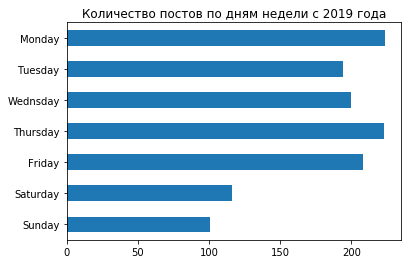

In [59]:
# Посчитаем общее количество постов по дням недели
Skillbox_wall_df.loc[:, 'dayofweek'] = Skillbox_wall_df.date.dt.dayofweek
weekday_distribution = Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019].groupby('dayofweek')['id'].count()
weekday_distribution.index = [DAYS_OF_WEEK[x] for x in weekday_distribution.index]
weekday_distribution.plot(kind='barh', title='Количество постов по дням недели c 2019 года').get_figure().gca().invert_yaxis()

pass

### Выводы

- <b>Просмотры:</b> Посты, опубликованные в воскресенье и среду, в среднем набирают большее количество просмотров, чем опубликованные в другие дни недели. 

- <b>Лайки:</b> Публикации, сделанные в воскресенье собирают в два раза больше лайков, чем в любой другой день недели

- <b>Репосты:</b> Аналогично лайкам, пользователи делают в два раза больше репостов публикаций воскресенья, чем любого другого дня недели

- <b>Комменты:</b> Посты, опубликованные в четверг, собирали в последние 3 года наибольшее количество лайков, однако, последний год посты, опубликованные в среду, существенно 




Для проверки гипотезы мы рассмотрели удельное количество вовлеченностей (комменты, лайки, репосты и просмотры) для каждого дня недели. Далее мы сравнили их между собой. Для дополнительной проверки мы рассмотрели данные отдельно за 2020, 2019 и справочно 2018 года.

<i>Ниже представлена таблица количества вовлеченностей (всего и удельно на пост) для каждого дня недели c 2019 года</i>

In [60]:
def impressions_per_weekday(impression='likes', start_period=np.min(Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019, 'date']), end_period=Skillbox_wall_df.date[0]):
    """Функция считает удельное количество вовлеченностей в каждый день недели 
    Параметры:
    impression - вид вовлеченности
    start_period - начало анализа (datetime64)
    end_period - конец анализа (datetime64)
    """
    temp = Skillbox_wall_df.loc[(Skillbox_wall_df.date >= start_period) & (Skillbox_wall_df.date <= end_period)].copy()

    # Предварительно в исходный датасет добавляем параметры недели и дня недели
    temp.loc[:, 'week'] = temp.date.dt.week
    temp.loc[:, 'dayofweek'] = temp.date.dt.dayofweek
    
    # Считаем количество лайков в каждый день недели по неделям
    impressions_per_week = temp.groupby(['dayofweek'])[[impression]].sum()
    impressions_per_week['posts_number'] = temp.groupby(['dayofweek'])['id'].count()
    impressions_per_week[f'{impression}_per_post'] = impressions_per_week[impression] / impressions_per_week['posts_number']
    impressions_per_week.index = [DAYS_OF_WEEK[x] for x in impressions_per_week.index]
    return impressions_per_week

In [61]:
def all_impressions_per_weekday(start_period=np.min(Skillbox_wall_df.date), end_period=Skillbox_wall_df.date[0]):
    """Функция считает вовлеченности по дням недели и удельные вовлеченности для всех типов"""
    impressions_weekday = []

    for impression in IMPRESSION_TYPES:
        temp = impressions_per_weekday(impression, start_period, end_period)
        impressions_weekday.append(temp)

    # Объединяем 4 полученных датафрейма в один с MultiIndex columns
    impressions_weekday = pd.concat([x for x in impressions_weekday], keys = IMPRESSION_TYPES, axis=1)
    return impressions_weekday
all_impressions_per_weekday()

views                              likes               \
              views posts_number views_per_post  likes posts_number   
Monday    4444590.0          400   11111.475000  20448          400   
Tuesday   3879513.0          375   10345.368000  16959          375   
Wednsday  6380446.0          372   17151.736559  23241          372   
Thursday  4331414.0          380   11398.457895  19044          380   
Friday    4566224.0          394   11589.401015  24738          394   
Saturday  2811605.0          205   13715.146341  13391          205   
Sunday    3035806.0          173   17548.011561  20534          173   

                        reposts                               comments  \
         likes_per_post reposts posts_number reposts_per_post comments   
Monday        51.120000    2786          400         6.965000     2413   
Tuesday       45.224000    2293          375         6.114667     1971   
Wednsday      62.475806    3270          372         8.790323     2736   
Thursday      50.115789    2677          380         7.044737     3966   
Friday        62.786802    3555          394         9.022843     1782   
Saturday      65.321951    1712          205         8.351220      977   
Sunday       118.693642    3271          173        18.907514     1259   

                                         
         posts_number comments_per_post  
Monday            400          6.032500  
Tuesday           375          5.256000  
Wednsday          372          7.354839  
Thursday          380         10.436842  
Friday            394          4.522843  
Saturday          205          4.765854  
Sunday            173          7.277457

<i>Графически количество вовлеченностей по годам представлено ниже:</i>

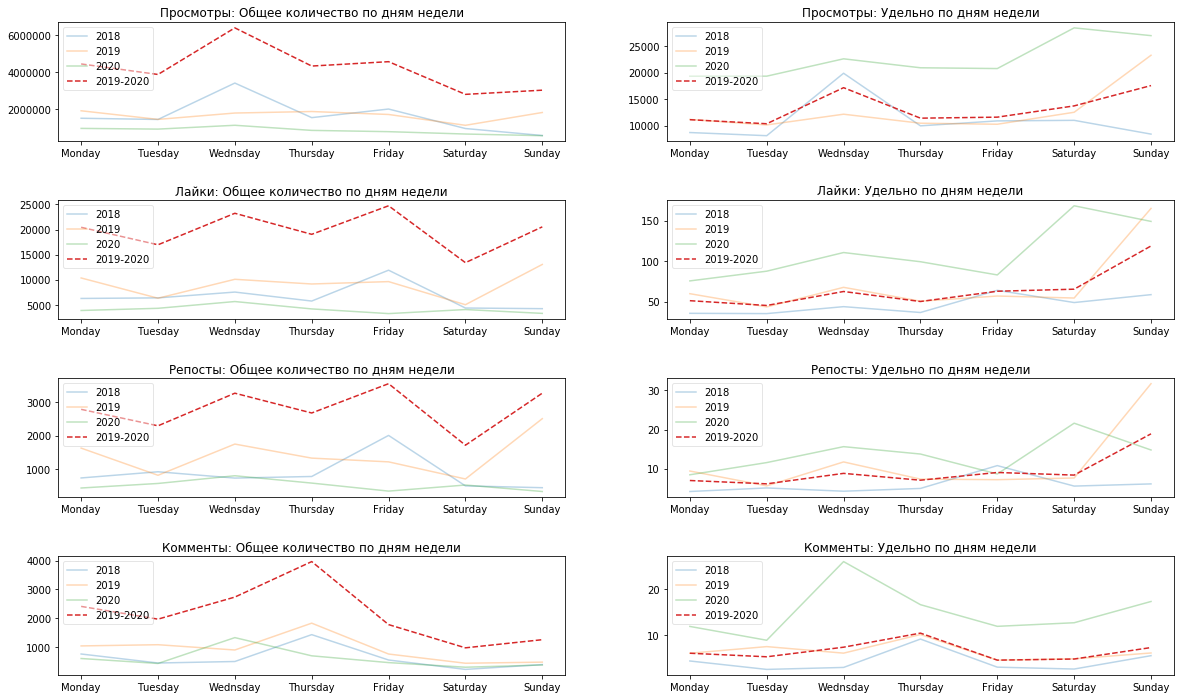

In [63]:
## Графиков будет 4 штуки для каждого типа вовлеченности, при этом график для типа вовлеченности будет состоять из 2х частей - абсолютный и удельный показатель
def plot_impressions_per_weekday(years=[2018, 2019, 2020]):
    """Функция строит графики для выбранных лет"""
    if not type(years) == list:
        raise ValueError('Введите список лет для посроения графиков') 
    fig, subplot = plt.subplots(4,2)
    plt.subplots_adjust(hspace = 0.5)
    for year in years:
        # Для заданного года получаем данные
        start_period = pd.to_datetime(f'{year}-01-01')
        end_period = start_period + np.timedelta64(1, 'Y')
        impressions_weekday=all_impressions_per_weekday(start_period, end_period)
        
        # Строим по 4 графика на каждый тип вовлеченности
        for i, impression in enumerate(IMPRESSION_TYPES):
            absolute = impressions_weekday[impression][impression]
            subplot[i][0].plot(absolute, label=year, alpha=0.3)
            relative = impressions_weekday[impression][f'{impression}_per_post']
            subplot[i][1].plot(relative, label=year, alpha=0.3)
            
    # После того как построены графики для каждого года, добавляем еще общую линию 2018-2020
    impressions_weekday = all_impressions_per_weekday()
    for i, impression in enumerate(IMPRESSION_TYPES):    
        absolute = impressions_weekday[impression][impression]
        subplot[i][0].plot(absolute, label="2019-2020", linestyle='--', )
        relative = impressions_weekday[impression][f'{impression}_per_post']
        subplot[i][1].plot(relative, label="2019-2020", linestyle='--')
        # Задаем подписи и выводим легенду
        subplot[i][0].set_title(f'{TITLES[impression]}: Общее количество по дням недели')
        subplot[i][0].legend(loc='upper left', framealpha=0.5)
        subplot[i][1].set_title(f'{TITLES[impression]}: Удельно по дням недели')
        subplot[i][1].legend(loc='upper left', framealpha=0.5)
        
    fig.set_figwidth(20)
    fig.set_figheight(12)
plot_impressions_per_weekday()

### Гипотеза 2: В рабочие дни вовлеченность пользователей выше

Мы обнаружили, что в субботу и воскресенье вовлеченность пользователей выше почти по всем метрикам. 

Проверим, на сколько один пост в выходные получает вовлеченности больше, чем в будние. Для этого мы посчитаем удельные метрики вовлеченности для рабочих дней и для выходных.

### Общее распределение постов по рабочим и выходным дням

Как видно из общего распределения постов - за все время существования группы Skillbox в выходные было сделано примерно в 3 раза меньше постов, чем в будние дни.

In [64]:
def is_business_day(date):
    """Проверка на рабочий день"""
    return bool(len(pd.bdate_range(date, date)))

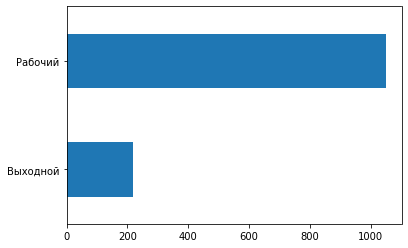

In [97]:
Skillbox_wall_df.loc[:, 'is_businessday'] = Skillbox_wall_df.date.apply(is_business_day)
businessday_distribution = Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019].groupby('is_businessday')['id'].count()
businessday_distribution.index = [BUSINESS_DAYS[x] for x in businessday_distribution.index]
businessday_distribution.plot(kind='barh')
pass

### Выводы

- <b>Просмотры, Лайки, Репосты:</b> Посты, опубликованные в выходные набирают наибольшее количество всех типов вовлеченностей, кроме комментариев

- <b>Комменты:</b> Посты, опубликованные в рабочие дни набирают большее количество комментов, чем те, что опубликованы в выходные.


<i>Ниже представлена таблица количества вовлеченностей (всего и удельно на пост) для выходных и рабочих дней c 2019 года</i>

In [69]:
def impressions_per_businessday(start_period = np.min(Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019, 'date']), end_period = Skillbox_wall_df.date[0]):
    """Функция считает количество вовлеченностей в рабочие и нерабочие дни"""
    temp = Skillbox_wall_df.loc[(Skillbox_wall_df.date >= start_period) & (Skillbox_wall_df.date <= end_period)].copy()
    temp['is_businessday'] = temp['date'].apply(is_business_day)
    impressions_per_businessday = temp.groupby('is_businessday')[IMPRESSION_TYPES].sum()
    impressions_per_businessday['posts_number'] = temp.groupby('is_businessday')[['id']].count()
    # Далее считаем удельные показатели
    for impression in IMPRESSION_TYPES:
        impressions_per_businessday[f'{impression}_per_post'] = impressions_per_businessday[impression] / impressions_per_businessday['posts_number']
    # Задаем явный вид подписи для индекса
    impressions_per_businessday.index = [BUSINESS_DAYS[x] for x in impressions_per_businessday.index]
    return impressions_per_businessday
impressions_per_businessday()

,views,likes,reposts,comments,posts_number,views_per_post,likes_per_post,reposts_per_post,comments_per_post
Выходной,4265349.0,25361,4051,1611,217,19655.986175,116.870968,18.668203,7.423963
Рабочий,13603489.0,66652,9427,9162,1049,12968.054337,63.538608,8.986654,8.734032


<i>Графически количество вовлеченностей в рабочие дни и выходные:</i>

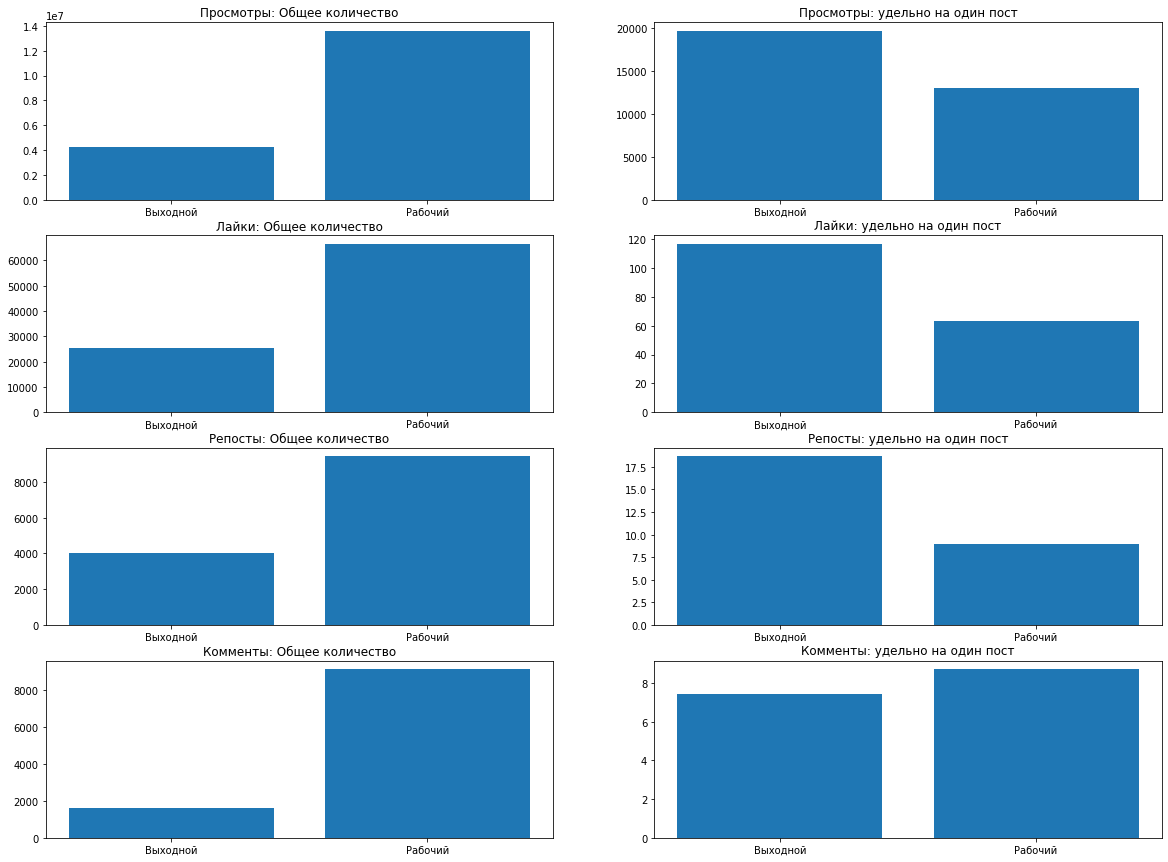

In [70]:
to_chart = impressions_per_businessday()
fig, subplot = plt.subplots(4,2)
for i, impression in enumerate(IMPRESSION_TYPES):
    x = to_chart[impression].index
    y = to_chart[impression]
    subplot[i][0].bar(x, y)
    subplot[i][0].set_title(f'{TITLES[impression]}: Общее количество')
    y = to_chart[f'{impression}_per_post']
    subplot[i][1].bar(x, y)
    subplot[i][1].set_title(f'{TITLES[impression]}: удельно на один пост')
fig.set_figwidth(20)
fig.set_figheight(15)

### Гипотеза 3: Время публикации влияет на количество вовлеченностей

Мы выяснили, что посты, сделанные в выходные дни собирают большее количество лайков, репостов и просмотров, поэтому далее посмотрим в какое время суток внутри дня лучше публиковать новые посты.

Для анализа день был разделен на 4 группы:

- `Утро` с 4 утра до 12 дня
- `День` с 12 до 6 часов вечера
- `Вечер` с 6 часов до 12 ночи
- `Ночь` с 12 до 4 утра


### Выводы

In [262]:
def get_impressions_per_day_time(start_period = np.min(Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019, 'date']), end_period = Skillbox_wall_df.date[0]):
    """Функция возвращает удельное количество вовлеченностей для разного времени суток для каждого дня недели"""
    analyzed_df = Skillbox_wall_df.loc[(Skillbox_wall_df.date >= start_period) & (Skillbox_wall_df.date <= end_period)].copy()
    analyzed_df = analyzed_df.set_index('date')
    analyzed_df['day_time'] = 0
    
    # Делаем разметку времени
    for time in TIME_OF_DAY.keys():
        chosen_time = analyzed_df.between_time(TIME_OF_DAY[time][0], TIME_OF_DAY[time][1]).index
        analyzed_df.loc[chosen_time, 'day_time'] = time
    # Группируем по времени и дню недели
    impressions_by_daytime = analyzed_df.groupby(['day_time', 'dayofweek'])[IMPRESSION_TYPES].sum()
    impressions_by_daytime['post_numbers'] = analyzed_df.groupby(['day_time', 'dayofweek'])['id'].count()
    # Считаем удельное количество для каждого типа вовлеченности
    for impression in IMPRESSION_TYPES:
        impressions_by_daytime[impression] = impressions_by_daytime[impression] / impressions_by_daytime['post_numbers']
    # Дни недели обозначаем привычным видом
    impressions_by_daytime.index = pd.MultiIndex.from_tuples([(x[0], DAYS_OF_WEEK[x[1]]) for x in impressions_by_daytime.index], names=impressions_by_daytime.index.names)
    return impressions_by_daytime
#get_impressions_per_day_time()

- <b>Общие выводы:</b> Утренние посты набирают большее количество взаимодействий, чем посты в другое время суток.

- <b>Просмотры, Лайки, Репосты:</b> Наибольшее количество взаимодействий набирают воскресные утренние посты

- <b>Комменты:</b> Утренние посты в четверг собирают наибольшее количество комментов.


<i>Количество вовлеченностей по времени дня в разрезе дней недели:</i>

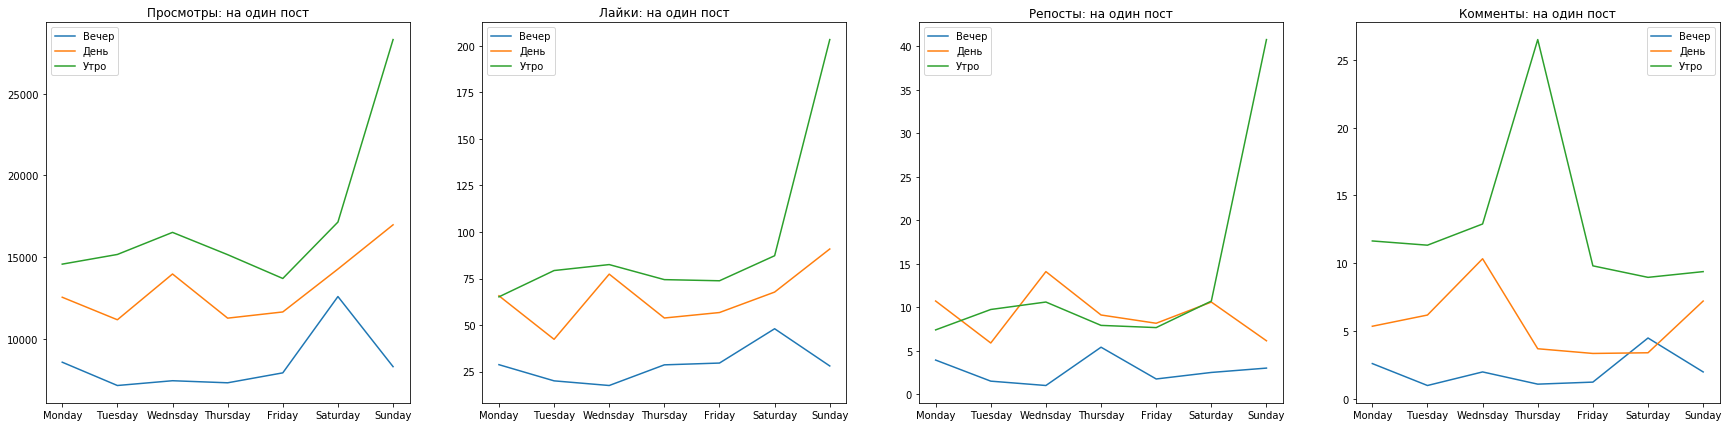

In [263]:
fig, subplot = plt.subplots(1, 4)
impressions_by_daytime = get_impressions_per_day_time()
day_times = impressions_by_daytime.index.get_level_values(0).unique()

for day_time in day_times:
    for i, impression in enumerate(IMPRESSION_TYPES):
        x = impressions_by_daytime.loc[day_time].index.to_list()
        y = impressions_by_daytime.loc[day_time][impression]
        subplot[i].plot(x, y, label=day_time)
        subplot[i].set_title(f'{TITLES[impression]}: на один пост')
        subplot[i].legend()
fig.set_figwidth(30)
fig.set_figheight(7)

### Гипотеза 4: Количество вложений влияет на вовлеченность

Мы предполагаем, что пост без приложенных материалов (фото, ссылок и др.) набирает в вовлеченностей меньше, чем это делают посты с приложенными материалами.

### Общее распределение постов по количеству приложений

За 2019-2020 год Skillbox опубликовал более 980 публикаций с одним приложением. Вариативность количества приложенных материалов не высокая.

Для проверки гипотезы также, как в предыдущих упражнениях посчитаем удельное количество взаимодействий на пост. Для более корректных выводов из анализа были исключены все группы, где общее количество постов было меньше 20. Где

In [72]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

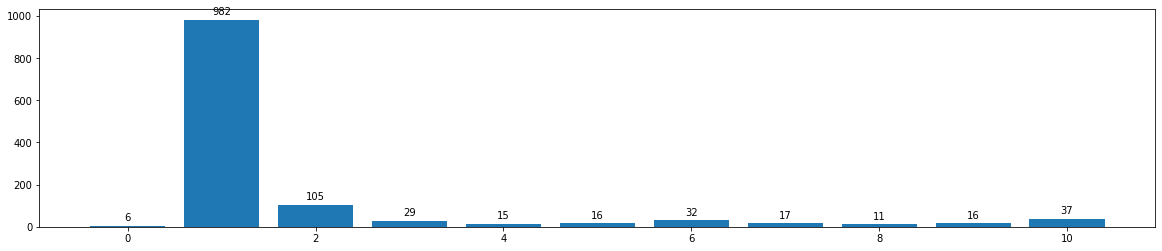

In [73]:
number_of_attachments = Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019].groupby('attachments_count')['id'].count()
number_of_attachments = number_of_attachments.sort_values(ascending=False)
fig, subplot = plt.subplots()
x = number_of_attachments.index
y = number_of_attachments.values

rect = subplot.bar(x, y)
autolabel(rect)
fig.set_figwidth(20)

### Выводы

- <b>Общие выводы:</b> Поскольку группы маленькие выводы статистически малозначимы

In [76]:
def impressions_per_number_of_attachments(start_period = np.min(Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019, 'date']), end_period = Skillbox_wall_df.date[0]):
    """Функция считает количество вовлеченностей в рабочие и нерабочие дни"""
    temp = Skillbox_wall_df.loc[(Skillbox_wall_df.date >= start_period) & (Skillbox_wall_df.date <= end_period)].copy()
    impressions_per_attachments_count = temp.groupby('attachments_count')[IMPRESSION_TYPES].sum()
    impressions_per_attachments_count['posts_number'] = temp.groupby('attachments_count')[['id']].count()
    impressions_per_attachments_count = impressions_per_attachments_count.loc[impressions_per_attachments_count['posts_number'] >= POSTS_THRESHOLD]
    # Далее считаем удельные показатели
    for impression in IMPRESSION_TYPES:
        impressions_per_attachments_count[f'{impression}_per_post'] = impressions_per_attachments_count[impression] / impressions_per_attachments_count['posts_number']
    # Задаем явный вид подписи для индекса
    #impressions_per_attachments_count.index = [BUSINESS_DAYS[x] for x in impressions_per_attachments_count.index]
    return impressions_per_attachments_count
impressions_per_number_of_attachments()

,views,likes,reposts,comments,posts_number,views_per_post,likes_per_post,reposts_per_post,comments_per_post
attachments_count,,,,,,,,,
1,11788503.0,56464,7706,7364,982,12004.585540,57.498982,7.847251,7.498982
2,1303559.0,3430,345,1881,105,12414.847619,32.666667,3.285714,17.914286
3,551924.0,3576,834,156,29,19031.862069,123.310345,28.758621,5.379310
6,861485.0,5799,856,314,32,26921.406250,181.218750,26.750000,9.812500
10,1265053.0,8884,1517,302,37,34190.621622,240.108108,41.000000,8.162162


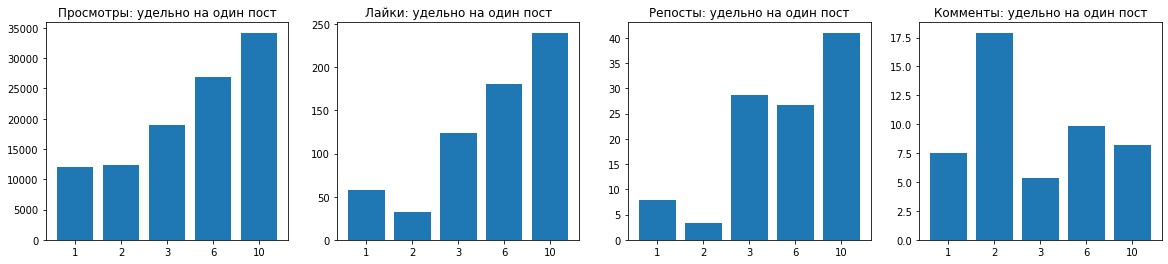

In [266]:
def chart_attachments_count(year=[2020, 2019, 2018]):
    to_chart = impressions_per_number_of_attachments()
    fig, subplot = plt.subplots(1,4)
    for i, impression in enumerate(IMPRESSION_TYPES):
        x = to_chart[impression].index
        x = [str(var) for var in x]
        y = to_chart[f'{impression}_per_post']
        rect = subplot[i].bar(x, y)
        subplot[i].set_title(f'{TITLES[impression]}: удельно на один пост')

    fig.set_figwidth(20)
    
chart_attachments_count()

### Гипотеза 5: Тип вложений в записи влияет на вовлеченность

### Общее распределение постов по типам приложений

Поскольку гипотеза с количеством вложений не получилось проверить, проверим как влияет тип вложения и количество приложений.

Две ключевые группы - это посты с фото и ссылкой

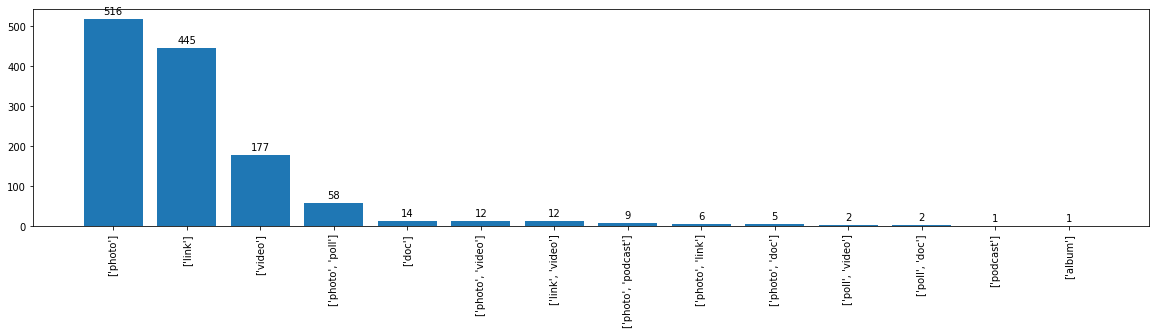

In [268]:
attachements_type_distribution = Skillbox_wall_df.loc[Skillbox_wall_df.date.dt.year >= 2019]
attachements_type_distribution = attachements_type_distribution.groupby('attachments')['id'].count().sort_values(ascending=False)
fig, subplot = plt.subplots()
x = attachements_type_distribution.index
y = attachements_type_distribution.values

rect = subplot.bar(x, y)
plt.xticks(rotation='vertical')
autolabel(rect)
fig.set_figwidth(20)

### Выводы

- Посты с фото набирают больше комментариев, чем посты с одной ссылкой, при это по остальным параметрам довольно близкие показатели
- Вероятнее всего на вовлеченность по разным типам вложений влияют рубрики постов (одни используюют опросы, другие фото-альбомы, другие ссылки), поэтому четких рекомендаций на базе типов вложений не сделать

In [18]:
def impressions_per_attachments_type(start_period = Skillbox_wall_df.date[0] - np.timedelta64(1, 'Y'), end_period = Skillbox_wall_df.date[0]):
    """Функция считает количество вовлеченностей в рабочие и нерабочие дни"""
    temp = Skillbox_wall_df.loc[(Skillbox_wall_df.date >= start_period) & (Skillbox_wall_df.date <= end_period)].copy()
    impressions_per_attachments_type = temp.groupby(['attachments', 'attachments_count'])[IMPRESSION_TYPES].sum()
    impressions_per_attachments_type['posts_number'] = temp.groupby(['attachments', 'attachments_count'])[['id']].count()
    impressions_per_attachments_type = impressions_per_attachments_type.loc[impressions_per_attachments_type['posts_number'] >= POSTS_THRESHOLD]
    # Далее считаем удельные показатели
    for impression in IMPRESSION_TYPES:
        impressions_per_attachments_type[f'{impression}_per_post'] = impressions_per_attachments_type[impression] / impressions_per_attachments_type['posts_number']
    # Задаем явный вид подписи для индекса
    #impressions_per_attachments_count.index = [BUSINESS_DAYS[x] for x in impressions_per_attachments_count.index]
    return impressions_per_attachments_type
impressions_per_attachments_type()

comments  likes  reposts      views  \
attachments       attachments_count                                        
['link']          1                       758  12002     1844  2428766.0   
['photo', 'poll'] 2                      1295    765       35   474547.0   
['photo']         1                      3815  12983     1706  3432772.0   
                  6                       310   4650      575   760889.0   
                  10                      272   5746      731   926375.0   
['video']         1                       651   5053      407  1017275.0   

                                     posts_number  comments_per_post  \
attachments       attachments_count                                    
['link']          1                           202           3.752475   
['photo', 'poll'] 2                            36          35.972222   
['photo']         1                           240          15.895833   
                  6                            29          10.689655   
                  10                           30           9.066667   
['video']         1                            62          10.500000   

                                     likes_per_post  reposts_per_post  \
attachments       attachments_count                                     
['link']          1                       59.415842          9.128713   
['photo', 'poll'] 2                       21.250000          0.972222   
['photo']         1                       54.095833          7.108333   
                  6                      160.344828         19.827586   
                  10                     191.533333         24.366667   
['video']         1                       81.500000          6.564516   

                                     views_per_post  
attachments       attachments_count                  
['link']          1                    12023.594059  
['photo', 'poll'] 2                    13181.861111  
['photo']         1                    14303.216667  
                  6                    26237.551724  
                  10                   30879.166667  
['video']         1                    16407.661290

# Раздел 2: Аналитика по рубрикам

### Разметка текста по категориям

In [89]:
def find_category(text):
    """Функция определяет рубрику по хэш-тэгу"""
    try:
        category_pattern = r'#\w+'
        category = re.findall(category_pattern, text)
        if len(category) >= 1:
            category = [x.lower() for x in category]
            return category
    except TypeError:
        return None

Skillbox_wall_df['category'] =  Skillbox_wall_df['text'].apply(find_category)


### Распределение рубрик по годам

Самые публикуемые рубрики за 2019-2020 года: публикации по направлениям обучения Skillbox (дизайн, маркетинг, программирование, управление), другие рубрики включают - статьи, в закладки и вдохновляет.

Для отбора рубрик для анализа были использованы следующие условия:

- Использованы только рубрики, по которым были посты в 2020 году

- Рассмотрены рубрики по которым было более 10 постов

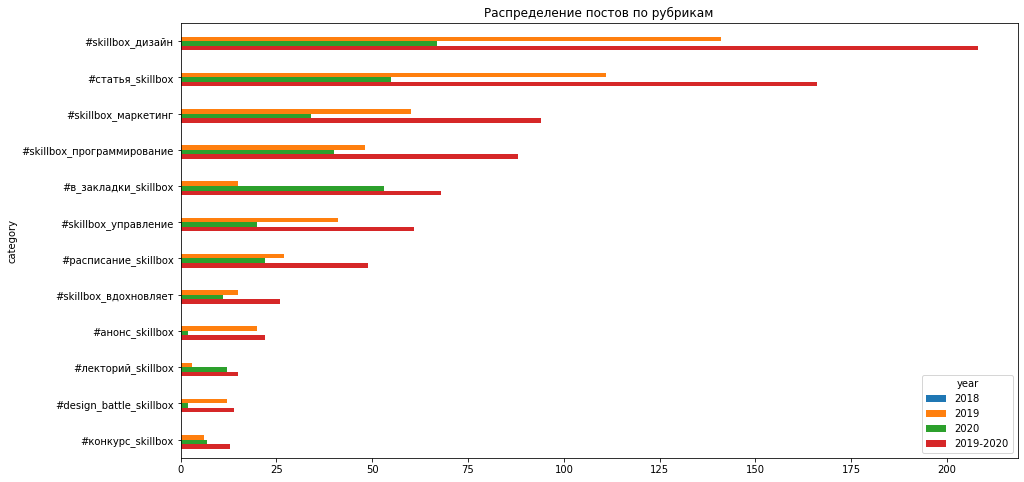

In [150]:

analyzed_df = Skillbox_wall_df.copy()
analyzed_df['year'] = analyzed_df['date'].dt.year
analyzed_df = analyzed_df.explode('category')
analyzed_df = analyzed_df.groupby(['year', 'category'])['id'].count().unstack('year')

# Убираем рубрики, по которым не было постов в 2020 году
analyzed_df = analyzed_df.loc[analyzed_df[2020].notna()]

analyzed_df['2019-2020'] = analyzed_df.loc[:,2019:2020].sum(axis=1)

# Оставляем рубрики по которым было более 10 постов
analyzed_df = analyzed_df.loc[analyzed_df['2019-2020'] >= 10]


analyzed_df = analyzed_df.sort_values('2019-2020', ascending=False)
fig = analyzed_df.plot(kind='barh', title='Распределение постов по рубрикам').get_figure()
fig.gca().invert_yaxis()
fig.set_figwidth(15)
fig.set_figheight(8)
analyzed_categories = analyzed_df.index
pass

### Выводы

- Больше всего вовлеченностей за один пост собирают рубрики: "В_закладки_Skillbox" и "Конкурс_Skillbox", особенно это выражается в 2020 году

- В 2020 году все рубрики собирают больше вовлеченностей больше, чем в предыдущие - это связано с ростом числа подписчиков в группе

- Меньше всего вовлеченностей собрала категория "Статья_Skillbox" - при этом это вторая рубрика по количеству публикаций

- Самые комментируемые рубрики относятся к конкурсам - "Конкурс_Skillbox" и "Design_Battle_Skillbox"

In [178]:
temp = Skillbox_wall_df.copy()
temp = temp.explode('category')

temp['year'] = temp['date'].dt.year

analyzed_df = temp.groupby(['category', 'year'])[IMPRESSION_TYPES].sum()
analyzed_df['post_numbers'] = temp.groupby(['category', 'year'])['id'].count()
analyzed_df = analyzed_df.loc[analyzed_categories].unstack('year')

impressions_per_category = []
for impression in analyzed_df.columns.get_level_values(0).unique():
    temp = analyzed_df[impression].copy()
    temp['2019-2020'] = temp.sum(axis=1)
    impressions_per_category.append(temp)
impressions_per_category = pd.concat([x for x in impressions_per_category], keys = analyzed_df.columns.get_level_values(0).unique(), axis=1)
del(analyzed_df)
impressions_per_category

views                        likes        \
year                             2019       2020  2019-2020   2019  2020   
category                                                                   
#design_battle_skillbox      156791.0    32371.0   189162.0    249    51   
#skillbox_вдохновляет        254914.0   247102.0   502016.0   1601  1272   
#skillbox_дизайн            1718350.0  1656651.0  3375001.0  10224  9785   
#skillbox_маркетинг          679923.0   785678.0  1465601.0   4098  4039   
#skillbox_программирование   573594.0   863901.0  1437495.0   3325  3819   
#skillbox_управление         530400.0   418757.0   949157.0   2062  2038   
#анонс_skillbox              310788.0    37120.0   347908.0    493    67   
#в_закладки_skillbox         369356.0  1616052.0  1985408.0   2955  9950   
#конкурс_skillbox             86383.0   193630.0   280013.0    259  1512   
#лекторий_skillbox            30624.0   186837.0   217461.0     62   448   
#расписание_skillbox         280914.0   393699.0   674613.0   1242  1349   
#статья_skillbox            1191526.0   854861.0  2046387.0   7103  3223   

                                     reposts                 comments       \
year                       2019-2020    2019  2020 2019-2020     2019 2020   
category                                                                     
#design_battle_skillbox          300      14     1        15      587   85   
#skillbox_вдохновляет           2873     112    67       179      201  133   
#skillbox_дизайн               20009    1318  1172      2490     1284  713   
#skillbox_маркетинг             8137     690   502      1192      501  583   
#skillbox_программирование      7144     407   468       875      349  401   
#skillbox_управление            4100     320   331       651      315  114   
#анонс_skillbox                  560      26     4        30       47    0   
#в_закладки_skillbox           12905     474  1359      1833      142  614   
#конкурс_skillbox               1771      13   319       332      135  869   
#лекторий_skillbox               510       2    39        41       11   35   
#расписание_skillbox            2591     114   128       242      293  249   
#статья_skillbox               10326    1141   481      1622      342  199   

                                     post_numbers                 
year                       2019-2020         2019 2020 2019-2020  
category                                                          
#design_battle_skillbox          672           12    2        14  
#skillbox_вдохновляет            334           15   11        26  
#skillbox_дизайн                1997          141   67       208  
#skillbox_маркетинг             1084           60   34        94  
#skillbox_программирование       750           48   40        88  
#skillbox_управление             429           41   20        61  
#анонс_skillbox                   47           20    2        22  
#в_закладки_skillbox             756           15   53        68  
#конкурс_skillbox               1004            6    7        13  
#лекторий_skillbox                46            3   12        15  
#расписание_skillbox             542           27   22        49  
#статья_skillbox                 541          111   55       166

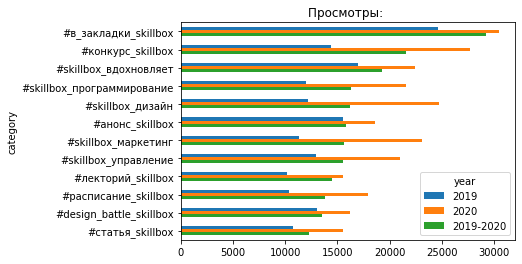

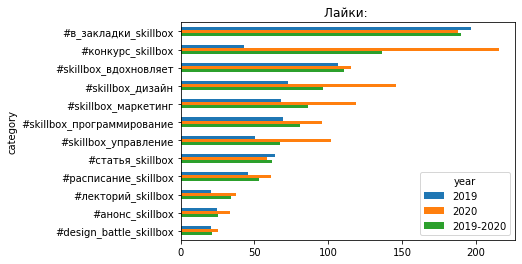

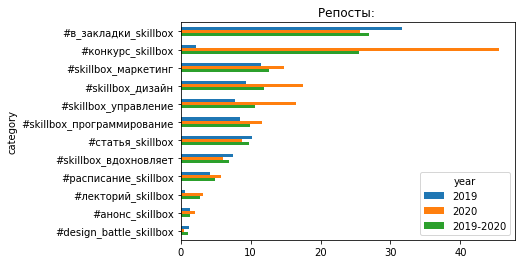

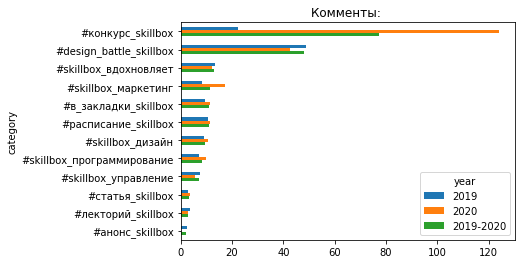

In [188]:
for element in IMPRESSION_TYPES:
    to_chart = impressions_per_category[element]
    to_chart = to_chart/ impressions_per_category['post_numbers']
    to_chart = to_chart.sort_values(by='2019-2020', ascending=False)
    fig = to_chart.plot(kind='barh', title = f'{TITLES[element]}: ').get_figure()
    fig.gca().invert_yaxis()

# Приложение: структура данных для анализа

- Таблица `Skillbox_wall_df` содержит в себе срез ключевой информацию по постам со стены сообщества. Источником является результаты метода API wall.get
    - `id` - уникальный идентификатор записи со стены
    - `date` - дата записи
    - `post_type` - тип записи (у всех 'post')
    - `text` - текст в записи на стене
    - `attachments` - список из типов вложений на стене
    - `attachments_count` - количество вложений
    - `comments` - количество комментариев
    - `likes` - количество лайков записи
    - `reposts` - количество репостов записи
    - `views` - просмотры записей (есть только для записей с 2017 года)

## Ниже код для выгрузки стены Skillbox в DataFrame `Skillbox_wall_df`

In [ ]:
# Задаем параметры входа
login, password = 'enter login', 'enter password'

### >>> Функции обработки авторизации

In [2]:
def auth_handler():
    """ При двухфакторной аутентификации вызывается эта функция.
    """

    # Код двухфакторной аутентификации
    key = input("Enter authentication code: ")
    # Если: True - сохранить, False - не сохранять.
    remember_device = True

    return key, remember_device

def captcha_handler(captcha):
    """ При возникновении капчи вызывается эта функция и ей передается объект
        капчи. Через метод get_url можно получить ссылку на изображение.
        Через метод try_again можно попытаться отправить запрос с кодом капчи
    """

    key = input("Enter captcha code {0}: ".format(captcha.get_url())).strip()

    # Пробуем снова отправить запрос с капчей
    return captcha.try_again(key)

In [3]:
# Заводим сессию с обработчиком двухфакторной авторизации и капчей
vk_session = vk_api.VkApi(
    login, password,
    # функция для обработки двухфакторной аутентификации
    auth_handler=auth_handler,
    captcha_handler=captcha_handler
)

try:
    vk_session.auth()
except vk_api.AuthError as error_msg:
    print(error_msg)

# Создаем объект API
vk = vk_session.get_api()
tools = vk_api.VkTools(vk_session)

Enter authentication code:  751961


### >>> Выгрузка данных для `Skillbox_wall_df`

In [5]:
def get_Skillbox_wall():    
    """Вытаскивает итератор для прохода по всей стене Skillbox"""
    return tools.get_all_slow_iter('wall.get', 100, values={'owner_id': '-66669811'})

Задаем список атрибутов, которые необходимо вытащить из таблицы 

In [6]:
attributes = ['id', 'date', 'date', 'post_type', 'text', 
              'attachments', 'comments', 'likes', 'reposts', 'views']
# Группа элементов, где внутри идет список
itterable_attributes = {'attachments':'type'}
# Группа атрибутов-счетчиков
counting_attributes = {'comments':'count', 'likes':'count', 'reposts':'count', 'views':'count'}
# Здесь будет храниться список записей со стены
wall_posts = []
# Сохраняем итератор
wall = get_Skillbox_wall()

Циклически проходим все элементы итератора стены

In [7]:
for wall_element in wall:
    wall_note = {}  # Полученный в результате запроса API результат сохраняем в словарь, его будем хранить в списке wall_posts
    # Внутри каждого элемента wall_element проходим по заранее выбранным атрибутам
    for attribute in attributes:
        # Проходим по массиву и вытаскиваем 
        if attribute in itterable_attributes.keys():
            # Часть записей не имеет прикрепленных файлов, поэтому исопльзуем try
            try:
                list_of_attachments = [x[itterable_attributes[attribute]] for x in wall_element[attribute]]
                wall_note.update({attribute:list(set(list_of_attachments))})  # Перечисляем все уникальные типы вложений
                wall_note.update({attribute+'_count':len(list_of_attachments)})  # Сколько всего было вложений
            except KeyError:
                # В случае, если у записи нет attachment
                wall_note.update({attribute:None})
                wall_note.update({attribute+'_count':0})
                
        elif attribute in counting_attributes.keys():
            # С 2017 года ВК выводит на стене информацию о просмотрах, все записи до этой даты не имеют информации о просмотрах
            try:
                wall_note.update({attribute: wall_element[attribute][counting_attributes[attribute]]})
            except KeyError:
                wall_note.update({attribute: None})
        elif attribute == 'date':
            wall_note.update({attribute:pd.Timestamp(wall_element[attribute], unit='s')})
        else:
            wall_note.update({attribute:wall_element[attribute]})
    wall_posts.append(wall_note)
print('completed')

completed


### >>> Сохранение `Skillbox_wall_df` в DataFrame и экспорт в csv

In [15]:
Skillbox_wall_df = pd.DataFrame(wall_posts).set_index('id')

In [9]:
# После первого прогона сохраняем данные в csv файл
Skillbox_wall_df.to_csv('Skillbox wall.csv', decimal='.', sep=';')zz